In [2]:
# 1 — Setup (imports, device, paths, features, helpers)

import time, math, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

plt.rcParams["figure.dpi"] = 160

# ---- Paths (edit here if your layout differs)
DATA_ROOT   = Path("../data")
PROC_DIR    = DATA_ROOT / "processed"
STATS_DIR   = DATA_ROOT / "stats"
MODEL_DIR   = DATA_ROOT / "models"
FORE_DIR    = DATA_ROOT / "forecasts"         # subfolders created per K
RESULTS_DIR = DATA_ROOT / "results"
FIG_DIR     = RESULTS_DIR / "figures"
TAB_DIR     = RESULTS_DIR / "tables"
for d in [FORE_DIR, RESULTS_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ---- Feature order MUST match your training data
FEATURES = ["bh_mass","bh_acc","stellar_mass","sfr","halo_mass","vel_disp"]
F = len(FEATURES)

# ---- Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[1] Using device: {device}")

# ---- Load processed arrays + stats
ids_path   = PROC_DIR / "ids.npy"
snaps_path = PROC_DIR / "snapshots.npy"
feats_path = PROC_DIR / "features.npy"
mean_path  = STATS_DIR / "feat_mean.npy"
std_path   = STATS_DIR / "feat_std.npy"

ids   = np.load(ids_path)
snaps = np.load(snaps_path).astype(int)
Xraw  = np.load(feats_path).astype(np.float32)
mean  = np.load(mean_path).astype(np.float32)
std   = np.load(std_path).astype(np.float32)

assert Xraw.shape[1] == F, f"Expected {F} features but got {Xraw.shape[1]}"

def to_norm(x): return (x - mean) / (std + 1e-8)
def to_real(z): return z * std + mean

# ---- Simple metrics
def rmse(A, B, axis=0): return np.sqrt(np.mean((A - B) ** 2, axis=axis))
def mae(A, B, axis=0):  return np.mean(np.abs(A - B), axis=axis)

print(f"[1] Loaded: ids={ids.shape}, snaps={snaps.shape}, features={Xraw.shape}, stats={mean.shape}/{std.shape}")


[1] Using device: cpu
[1] Loaded: ids=(37500,), snaps=(37500,), features=(37500, 6), stats=(6,)/(6,)


In [3]:
# 2 — Model rebuild + checkpoint load (+WINDOW)

class BHSequenceLSTM(nn.Module):
    def __init__(self, input_size, hidden=128, layers=2, dropout=0.1, output_size=None):
        super().__init__()
        if output_size is None: output_size = input_size
        self.lstm = nn.LSTM(
            input_size, hidden, num_layers=layers, batch_first=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, output_size)
        )
    def forward(self, x):            # x: [B, W, F]
        h, _ = self.lstm(x)          # [B, W, H]
        return self.head(h[:, -1, :])# [B, F]

# Load checkpoint
CKPT_PATH = MODEL_DIR / "blackhole_evolution_lstm.pt"
ckpt = torch.load(CKPT_PATH, map_location="cpu")
WINDOW = int(ckpt.get("window", 8))
print(f"[2] Loaded checkpoint: {CKPT_PATH.name} | WINDOW={WINDOW}")

# Build model as trained
model = BHSequenceLSTM(input_size=F, hidden=128, layers=2, dropout=0.1, output_size=F).to(device)
model.load_state_dict(ckpt["state_dict"])
model.eval()
print("[2] Model ready.")


[2] Loaded checkpoint: blackhole_evolution_lstm.pt | WINDOW=8
[2] Model ready.


[3] step 1/10 | elapsed 0.3s | ETA 2.5s
[3] step 2/10 | elapsed 0.3s | ETA 1.3s
[3] step 3/10 | elapsed 0.4s | ETA 0.9s
[3] step 4/10 | elapsed 0.4s | ETA 0.6s
[3] step 5/10 | elapsed 0.5s | ETA 0.5s
[3] step 6/10 | elapsed 0.5s | ETA 0.3s
[3] step 7/10 | elapsed 0.6s | ETA 0.2s
[3] step 8/10 | elapsed 0.6s | ETA 0.2s
[3] step 9/10 | elapsed 0.7s | ETA 0.1s
[3] step 10/10 | elapsed 0.7s | ETA 0.0s
[3] Finished K=10 for N=2500 subhalos in 0.7s (~0.07s/step)
[3] Wrote 2500 per-subhalo CSVs → ../data/forecasts/extrapolated_K10
[3] Aggregate: ../data/results/tables/forecast_mean_trajectory_K10.csv
[3] Figure:    ../data/results/figures/forecast_mean_trajectory_K10.png


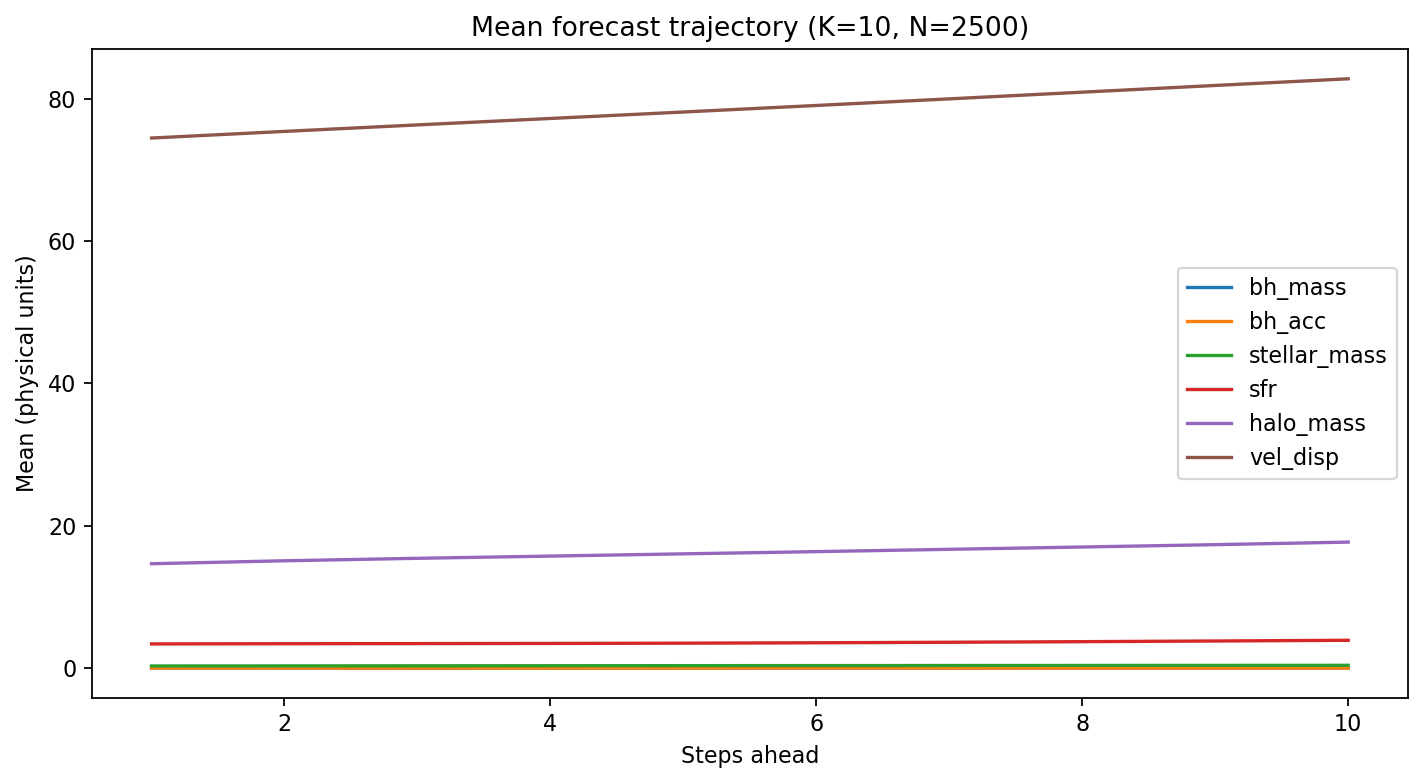

In [5]:
# 3 — Multi-step forecasts (K-step, batched, progress ETA)
# Builds last-window per subhalo, rolls forward K steps, saves per-subhalo CSVs + aggregate mean trajectory and figure.

K = 10              # change as you like (e.g., 20)
SUBSET_N = None     # e.g., 500 to test quickly; None = all eligible
PROGRESS_EVERY = 1  # print every k steps

csv_long_path = PROC_DIR / "black_hole_evolution_tng100.csv"
df_long = pd.read_csv(csv_long_path)

# Collect last windows
win_list, sid_list, last_snap_list = [], [], []
for sid in np.unique(ids):
    sub = df_long[df_long["subhalo_id"] == sid].sort_values("snapshot")
    if len(sub) < WINDOW: 
        continue
    Xw_real = sub[FEATURES].iloc[-WINDOW:].to_numpy(dtype=np.float32)
    win_list.append(Xw_real)
    sid_list.append(int(sid))
    last_snap_list.append(int(sub["snapshot"].iloc[-1]))

if SUBSET_N is not None:
    win_list       = win_list[:SUBSET_N]
    sid_list       = sid_list[:SUBSET_N]
    last_snap_list = last_snap_list[:SUBSET_N]

N = len(win_list)
if N == 0:
    raise RuntimeError("No subhalos have ≥ WINDOW snapshots. Aborting.")

FORE_K_DIR = FORE_DIR / f"extrapolated_K{K}"
FORE_K_DIR.mkdir(parents=True, exist_ok=True)

# Prepare batch window (normalized)
Xw = (np.stack(win_list, axis=0) - mean) / (std + 1e-8)
Xw = np.nan_to_num(Xw, nan=0.0, posinf=0.0, neginf=0.0)
Xw_t = torch.from_numpy(Xw).float().to(device)  # [N,W,F]

# Storage for predictions (REAL units)
preds = np.empty((N, K, F), dtype=np.float32)

t0 = time.perf_counter()
for k in range(1, K + 1):
    with torch.no_grad():
        y_norm = model(Xw_t)  # [N,F], normalized
    y_real = (y_norm.cpu().numpy() * std + mean).astype(np.float32)
    y_real = np.maximum(y_real, 0.0)            # non-negative clamp
    preds[:, k-1, :] = y_real

    # slide window forward in normalized space
    y_norm_np = y_norm.cpu().numpy()[:, None, :]  # [N,1,F]
    Xw_np = Xw_t.cpu().numpy()
    Xw_np = np.concatenate([Xw_np[:, 1:, :], y_norm_np], axis=1)
    Xw_t = torch.from_numpy(Xw_np).float().to(device)

    if k % PROGRESS_EVERY == 0:
        elapsed = time.perf_counter() - t0
        eta = elapsed / k * (K - k)
        print(f"[3] step {k}/{K} | elapsed {elapsed:.1f}s | ETA {eta:.1f}s")

total = time.perf_counter() - t0
print(f"[3] Finished K={K} for N={N} subhalos in {total:.1f}s (~{total/max(K,1):.2f}s/step)")

# Save per-subhalo forecasts
paths = []
for i, sid in enumerate(sid_list):
    snaps_future = [last_snap_list[i] + h for h in range(1, K+1)]
    out_df = pd.DataFrame(preds[i], columns=FEATURES)
    out_df.insert(0, "snapshot", snaps_future)
    out_df.insert(0, "subhalo_id", sid)
    p = FORE_K_DIR / f"forecast_subhalo_{sid}_K{K}.csv"
    out_df.to_csv(p, index=False)
    paths.append(p)

# Aggregate mean trajectory
agg = []
for i in range(N):
    tmp = pd.DataFrame(preds[i], columns=FEATURES)
    tmp["step_ahead"] = np.arange(1, K+1)
    agg.append(tmp)
mean_traj = pd.concat(agg).groupby("step_ahead")[FEATURES].mean().reset_index()
mean_traj.to_csv(TAB_DIR / f"forecast_mean_trajectory_K{K}.csv", index=False)

plt.figure(figsize=(9,5))
for f in FEATURES:
    plt.plot(mean_traj["step_ahead"], mean_traj[f], label=f)
plt.xlabel("Steps ahead"); plt.ylabel("Mean (physical units)")
plt.title(f"Mean forecast trajectory (K={K}, N={N})")
plt.legend()
fig_mt = FIG_DIR / f"forecast_mean_trajectory_K{K}.png"
plt.tight_layout(); plt.savefig(fig_mt, dpi=200)

print(f"[3] Wrote {len(paths)} per-subhalo CSVs → {FORE_K_DIR}")
print(f"[3] Aggregate: {TAB_DIR / f'forecast_mean_trajectory_K{K}.csv'}")
print(f"[3] Figure:    {fig_mt}")


[4] horizon 1: N=17500 | RMSE(mean)=4.959e+00 | elapsed 1.8s
[4] horizon 2: N=15000 | RMSE(mean)=5.626e+00 | elapsed 2.6s
[4] horizon 3: N=12500 | RMSE(mean)=6.000e+00 | elapsed 3.4s
[4] horizon 4: N=10000 | RMSE(mean)=6.547e+00 | elapsed 4.5s
[4] horizon 5: N=7500 | RMSE(mean)=7.164e+00 | elapsed 5.4s
[4] horizon 6: N=5000 | RMSE(mean)=7.419e+00 | elapsed 6.8s
[4] horizon 7: N=2500 | RMSE(mean)=9.411e+00 | elapsed 7.1s
[4] horizon 8: 0 samples (skipping)
[4] horizon 9: 0 samples (skipping)
[4] horizon 10: 0 samples (skipping)
[4] Saved: ../data/results/tables/horizon_rmse.csv, ../data/results/tables/horizon_mae.csv, ../data/results/figures/horizon_rmse.png
[4] Sample counts per horizon: {1: 17500, 2: 15000, 3: 12500, 4: 10000, 5: 7500, 6: 5000, 7: 2500}


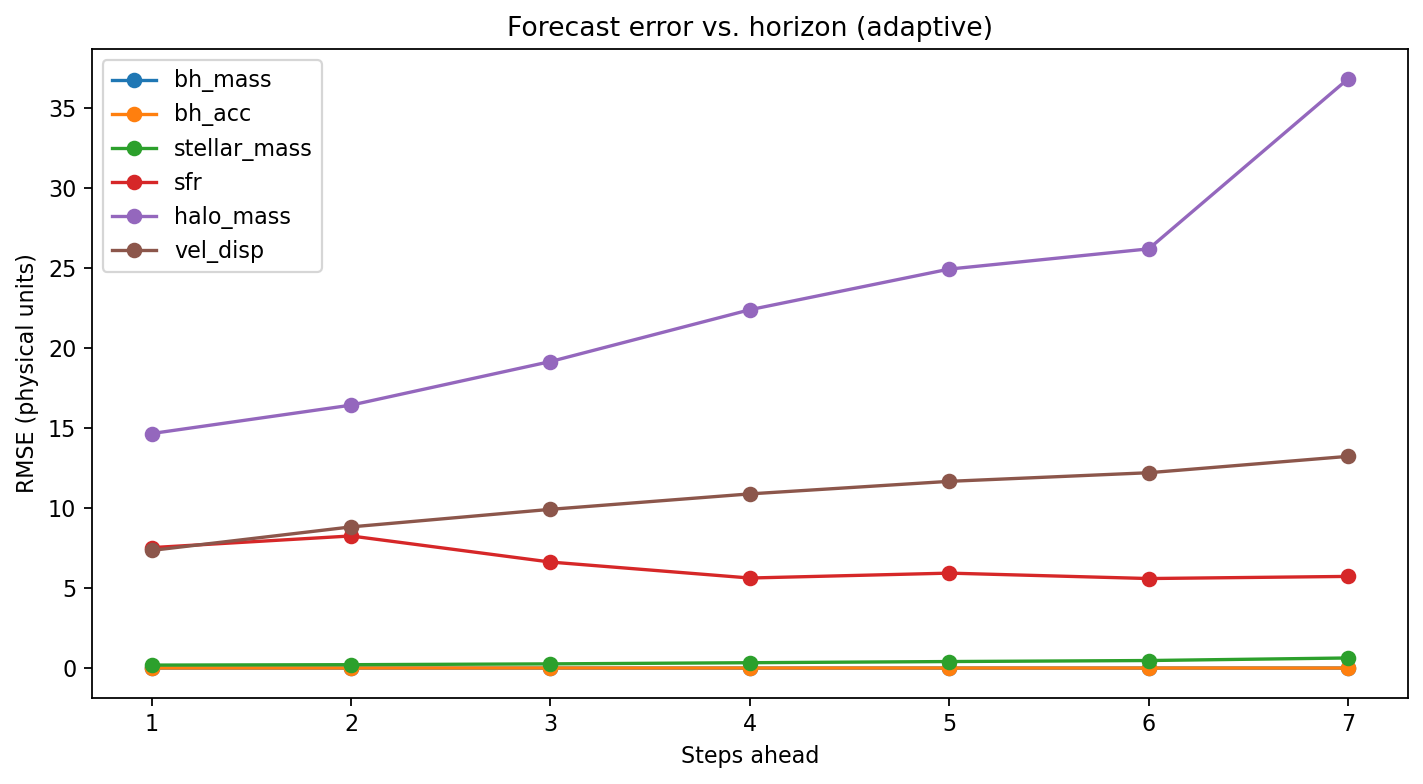

In [7]:
# 4 — Adaptive accuracy vs. horizon (works even when long futures are scarce)
# For each horizon h, only uses windows that truly have h future steps.
# It rolls the model h times from each window and compares to the true h-step-ahead target.

import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

K_eval = 10   # desired max horizon; will shrink automatically if needed
t0 = time.perf_counter()

# ---- Build normalized sequences per subhalo
seqs = {}
for sid in np.unique(ids):
    m = (ids == sid)
    s = snaps[m]
    x = Xraw[m]
    order = np.argsort(s)
    x = x[order]
    x = (x - mean) / (std + 1e-8)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    seqs[int(sid)] = x

# ---- Helper to collect windows that have >= h future steps, and their true h-step target
def collect_windows_for_h(seqs, h, window):
    XW_list, Y_list = [], []
    for sid, x in seqs.items():
        # need at least window + h samples to evaluate horizon h
        if len(x) < window + h:
            continue
        # windows ending at t-1 with future target at t+h-1 (0-index)
        # t ranges so that (t + h - 1) < len(x)  =>  t <= len(x) - h
        for t in range(window, len(x) - h + 1):
            XW_list.append(x[t-window:t, :])      # [W, F]
            Y_list.append(x[t + h - 1, :])        # [F]
    if not XW_list:
        return None, None
    return np.stack(XW_list).astype(np.float32), np.stack(Y_list).astype(np.float32)

# ---- Evaluate per-horizon with autoregressive rollouts
rmse_rows, mae_rows, counts = [], [], []

H_max_available = 0
for h in range(1, K_eval + 1):
    XW_h, Y_h = collect_windows_for_h(seqs, h, WINDOW)
    if XW_h is None:
        print(f"[4] horizon {h}: 0 samples (skipping)")
        continue

    H_max_available = h
    N_h = len(XW_h)
    counts.append((h, N_h))
    Xw_t = torch.from_numpy(XW_h).float().to(device)

    # roll h steps
    y_pred = None
    for step in range(h):
        with torch.no_grad():
            y_pred = model(Xw_t)                  # [N_h, F] (normalized)
        # slide window with the predicted step
        y_exp = y_pred[:, None, :].detach().cpu().numpy()
        Xw_np = Xw_t.cpu().numpy()
        Xw_np = np.concatenate([Xw_np[:, 1:, :], y_exp], axis=1)
        Xw_t = torch.from_numpy(Xw_np).float().to(device)

    # y_pred is the h-step prediction in normalized space; compare with Y_h
    P_r = y_pred.cpu().numpy() * std + mean
    T_r = Y_h * std + mean

    rmse_h = np.sqrt(np.mean((P_r - T_r) ** 2, axis=0))  # per feature
    mae_h  = np.mean(np.abs(P_r - T_r), axis=0)

    rmse_rows.append([h] + rmse_h.tolist())
    mae_rows.append([h]  + mae_h.tolist())

    elapsed = time.perf_counter() - t0
    print(f"[4] horizon {h}: N={N_h} | RMSE(mean)={rmse_h.mean():.3e} | elapsed {elapsed:.1f}s")

if H_max_available == 0:
    raise RuntimeError("No horizons available with current WINDOW. Try reducing WINDOW or ensure sequences are longer.")

# ---- Save tables
rmse_df = pd.DataFrame(rmse_rows, columns=["horizon"] + FEATURES)
mae_df  = pd.DataFrame(mae_rows,  columns=["horizon"] + FEATURES)
rmse_csv = TAB_DIR / "horizon_rmse.csv"
mae_csv  = TAB_DIR / "horizon_mae.csv"
rmse_df.to_csv(rmse_csv, index=False)
mae_df.to_csv(mae_csv,  index=False)

# ---- Plot RMSE vs horizon for features that have enough samples
plt.figure(figsize=(9,5))
for f in FEATURES:
    plt.plot(rmse_df["horizon"], rmse_df[f], marker="o", label=f)
plt.xlabel("Steps ahead"); plt.ylabel("RMSE (physical units)")
plt.title("Forecast error vs. horizon (adaptive)")
plt.legend()
fig_hr = FIG_DIR / "horizon_rmse.png"
plt.tight_layout(); plt.savefig(fig_hr, dpi=200)

print(f"[4] Saved: {rmse_csv}, {mae_csv}, {fig_hr}")
print("[4] Sample counts per horizon:", dict(counts))


[5] permuted bh_mass | ΔRMSE(mean)=3.225e-01
[5] permuted bh_acc | ΔRMSE(mean)=6.410e-02
[5] permuted stellar_mass | ΔRMSE(mean)=3.295e-01
[5] permuted sfr | ΔRMSE(mean)=9.933e-01
[5] permuted halo_mass | ΔRMSE(mean)=2.155e+00
[5] permuted vel_disp | ΔRMSE(mean)=2.659e+00
[5] Saved: ../data/results/tables/permutation_importance_ranked.csv, ../data/results/figures/permutation_importance.png


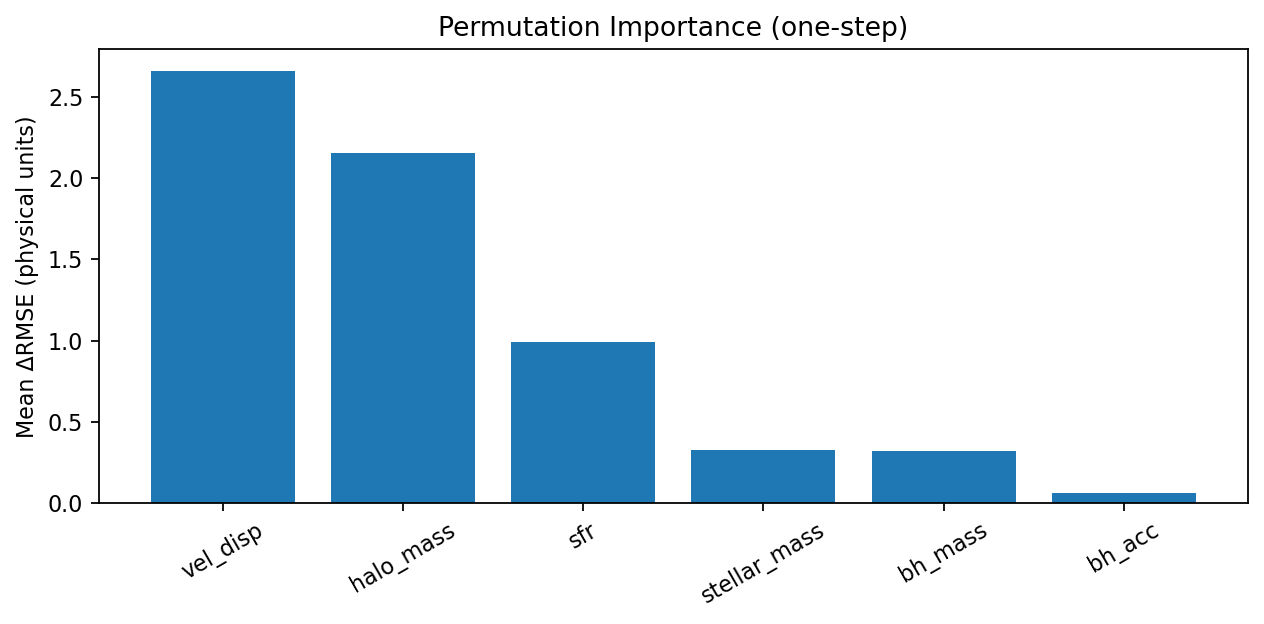

In [8]:
# 5 — Permutation importance (one-step; ΔRMSE in physical units) — self-contained

import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
rng = np.random.default_rng(42)

# --- Rebuild 1-step windows (normalized) for evaluation
XW_1, Y1 = [], []
for sid in np.unique(ids):
    m = (ids == sid)
    s = snaps[m]
    x = Xraw[m]
    order = np.argsort(s)
    x = x[order]
    x = (x - mean) / (std + 1e-8)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    if len(x) <= WINDOW:
        continue
    for t in range(WINDOW, len(x)):
        XW_1.append(x[t-WINDOW:t, :])  # [W, F]
        Y1.append(x[t, :])             # [F]

if not XW_1:
    raise RuntimeError("No 1-step windows available. Reduce WINDOW or check data length.")

XW_1 = np.stack(XW_1).astype(np.float32)   # [N,W,F]
Y1    = np.stack(Y1).astype(np.float32)    # [N,F]

@torch.no_grad()
def pred_norm(Xw):
    xb = torch.from_numpy(Xw).float().to(device)
    return model(xb).cpu().numpy()

# Baseline physical RMSE
P0   = pred_norm(XW_1)
P0_r = P0 * std + mean
Y1_r = Y1 * std + mean
base = np.sqrt(np.mean((P0_r - Y1_r)**2, axis=0))  # [F]

rows = []
for j_in, name in enumerate(FEATURES):
    Xp = XW_1.copy()
    # permute this input feature across samples at each time index
    for t in range(WINDOW):
        perm = rng.permutation(Xp.shape[0])
        Xp[:, t, j_in] = Xp[perm, t, j_in]
    Pp   = pred_norm(Xp)
    Pp_r = Pp * std + mean
    delta = np.sqrt(np.mean((Pp_r - Y1_r)**2, axis=0)) - base
    rows.append({"input_feature": name, **{f"ΔRMSE→{FEATURES[j]}": float(delta[j]) for j in range(F)}})
    print(f"[5] permuted {name} | ΔRMSE(mean)={float(delta.mean()):.3e}")

imp_df = pd.DataFrame(rows)
imp_df["ΔRMSE_mean"] = imp_df[[c for c in imp_df.columns if c.startswith("ΔRMSE→")]].mean(axis=1)
imp_df.sort_values("ΔRMSE_mean", ascending=False, inplace=True)

imp_csv = TAB_DIR / "permutation_importance_ranked.csv"
imp_df.to_csv(imp_csv, index=False)

plt.figure(figsize=(8,4))
plt.bar(imp_df["input_feature"], imp_df["ΔRMSE_mean"])
plt.xticks(rotation=30); plt.ylabel("Mean ΔRMSE (physical units)")
plt.title("Permutation Importance (one-step)")
fig_pi = FIG_DIR / "permutation_importance.png"
plt.tight_layout(); plt.savefig(fig_pi, dpi=200)

print(f"[5] Saved: {imp_csv}, {fig_pi}")


[6] PDP varied bh_mass
[6] PDP varied bh_acc
[6] PDP varied stellar_mass
[6] PDP varied sfr
[6] PDP varied halo_mass
[6] PDP varied vel_disp
[6] Saved ../data/results/figures/pdp_bh_mass.png
[6] Saved ../data/results/figures/pdp_bh_acc.png
[6] PDP table: ../data/results/tables/pdp_laststep_mean.csv


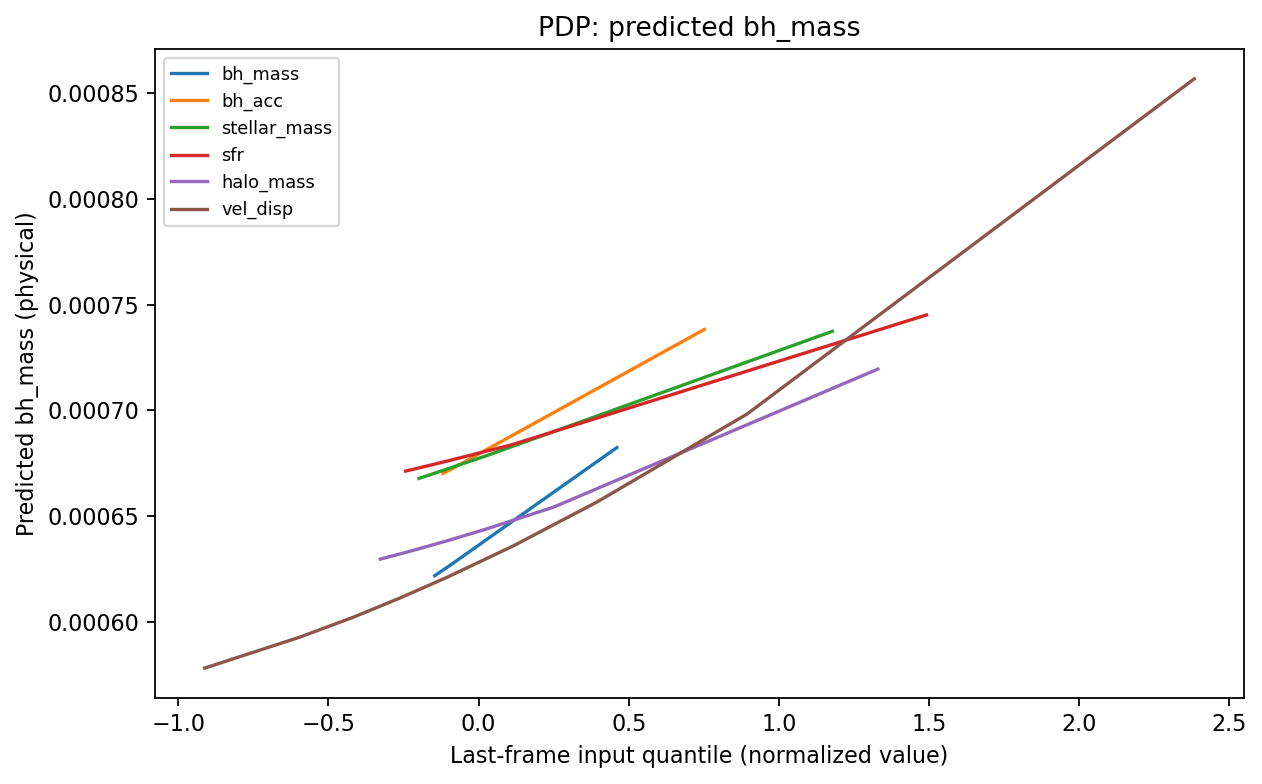

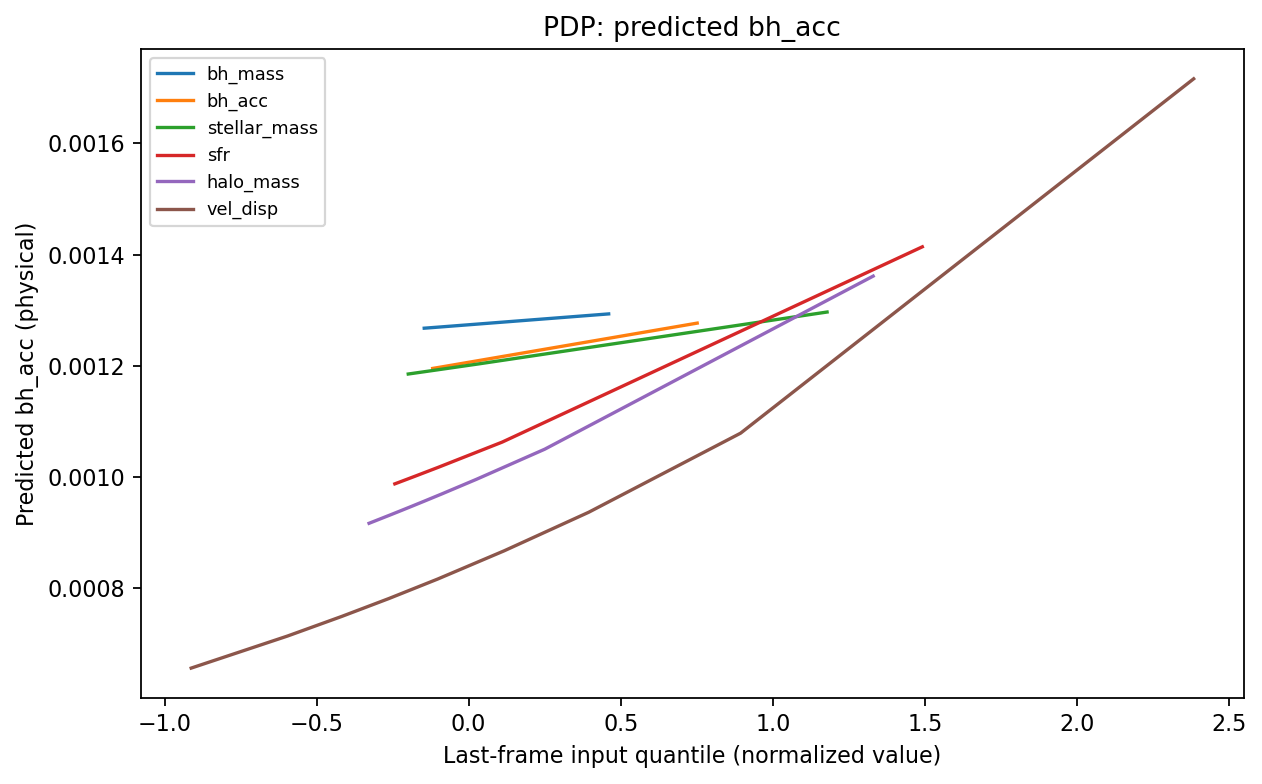

In [9]:
# 6 — Partial Dependence (vary last-frame input quantile; predicted outputs) — self-contained

import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt

# --- Rebuild a compact 1-step window set for PDP (normalized)
XW_pdp = []
for sid in np.unique(ids):
    m = (ids == sid)
    s = snaps[m]
    x = Xraw[m]
    order = np.argsort(s)
    x = x[order]
    x = (x - mean) / (std + 1e-8)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    if len(x) <= WINDOW:
        continue
    for t in range(WINDOW, len(x)):
        XW_pdp.append(x[t-WINDOW:t, :])
if not XW_pdp:
    raise RuntimeError("No PDP windows available. Reduce WINDOW or check data length.")
XW_pdp = np.stack(XW_pdp).astype(np.float32)

# Subsample for speed
N_sub = min(1000, len(XW_pdp))
idx = np.random.default_rng(123).choice(len(XW_pdp), size=N_sub, replace=False)
Xsub = XW_pdp[idx].copy()

quantiles = np.linspace(0.05, 0.95, 9)
rows = []

@torch.no_grad()
def predict_phys(Xw):
    z = model(torch.from_numpy(Xw).float().to(device)).cpu().numpy()
    return z * std + mean  # physical

for j_in, name in enumerate(FEATURES):
    base_vals = Xsub[:, -1, j_in]
    qs = np.quantile(base_vals, quantiles)
    for qv in qs:
        Xm = Xsub.copy()
        Xm[:, -1, j_in] = qv
        preds_r = predict_phys(Xm)      # [N_sub, F]
        mu = preds_r.mean(axis=0)       # [F]
        rows.append({
            "input_feature": name,
            "last_step_quantile": float(qv),
            **{f"pred_{FEATURES[j]}": float(mu[j]) for j in range(F)}
        })
    print(f"[6] PDP varied {name}")

pdp_df = pd.DataFrame(rows)
pdp_csv = TAB_DIR / "pdp_laststep_mean.csv"
pdp_df.to_csv(pdp_csv, index=False)

# Plot PDP for two key targets
for tgt in ["bh_mass","bh_acc"]:
    plt.figure(figsize=(8,5))
    for name in FEATURES:
        sub = pdp_df[pdp_df["input_feature"] == name].sort_values("last_step_quantile")
        plt.plot(sub["last_step_quantile"], sub[f"pred_{tgt}"], label=name)
    plt.xlabel("Last-frame input quantile (normalized value)")
    plt.ylabel(f"Predicted {tgt} (physical)")
    plt.title(f"PDP: predicted {tgt}")
    plt.legend(fontsize=8)
    fp = FIG_DIR / f"pdp_{tgt}.png"
    plt.tight_layout(); plt.savefig(fp, dpi=200)
    print(f"[6] Saved {fp}")

print(f"[6] PDP table: {pdp_csv}")


In [2]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn

# 1) Paths (non-destructive)
if "DATA_ROOT" not in globals():
    DATA_ROOT = Path("../data")
PROC_DIR    = DATA_ROOT / "processed"
STATS_DIR   = DATA_ROOT / "stats"
MODEL_DIR   = DATA_ROOT / "models"
RESULTS_DIR = DATA_ROOT / "results"
FIG_DIR     = RESULTS_DIR / "figures"
TAB_DIR     = RESULTS_DIR / "tables"
for d in [RESULTS_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# 2) Features (must match training)
if "FEATURES" not in globals():
    FEATURES = ["bh_mass","bh_acc","stellar_mass","sfr","halo_mass","vel_disp"]

# 3) Device
if "device" not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4) Load arrays from disk ONLY if missing
def _safe_load_np(var_name, path):
    if var_name not in globals():
        globals()[var_name] = np.load(path)
        print(f"[repair] loaded {var_name} from {path}")

if "ids"   not in globals():     _safe_load_np("ids",   PROC_DIR / "ids.npy")
if "snaps" not in globals():     
    _safe_load_np("snaps", PROC_DIR / "snapshots.npy")
    snaps = snaps.astype(int)
if "Xraw"  not in globals():     _safe_load_np("Xraw",  PROC_DIR / "features.npy")
if "mean"  not in globals():     _safe_load_np("mean",  STATS_DIR / "feat_mean.npy")
if "std"   not in globals():     _safe_load_np("std",   STATS_DIR / "feat_std.npy")

# 5) Model + WINDOW (only if missing)
if "WINDOW" not in globals() or "model" not in globals():
    # lightweight definition that matches the trained checkpoint
    class BHSequenceLSTM(nn.Module):
        def __init__(self, input_size, hidden=128, layers=2, dropout=0.1, output_size=None):
            super().__init__()
            if output_size is None: output_size = input_size
            self.lstm = nn.LSTM(
                input_size, hidden, num_layers=layers, batch_first=True,
                dropout=dropout if layers > 1 else 0.0
            )
            self.head = nn.Sequential(
                nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(hidden, output_size)
            )
        def forward(self, x):  # x: [B,W,F]
            h, _ = self.lstm(x)
            return self.head(h[:, -1, :])

    ckpt_path = MODEL_DIR / "blackhole_evolution_lstm.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    if "WINDOW" not in globals():
        WINDOW = int(ckpt.get("window", 8))
        print(f"[repair] set WINDOW={WINDOW} from checkpoint")
    if "model" not in globals():
        model = BHSequenceLSTM(input_size=len(FEATURES), hidden=128, layers=2, dropout=0.1, output_size=len(FEATURES)).to(device)
        model.load_state_dict(ckpt["state_dict"])
        model.eval()
        print("[repair] rebuilt model from checkpoint")

# 6) Tiny sanity print
needed = ["ids","snaps","Xraw","mean","std","WINDOW","model","device","FEATURES","TAB_DIR","FIG_DIR"]
missing = [n for n in needed if n not in globals()]
print("[repair] missing:", missing if missing else "none — ready for baseline cell")


[repair] loaded ids from ../data/processed/ids.npy
[repair] loaded snaps from ../data/processed/snapshots.npy
[repair] loaded Xraw from ../data/processed/features.npy
[repair] loaded mean from ../data/stats/feat_mean.npy
[repair] loaded std from ../data/stats/feat_std.npy
[repair] set WINDOW=8 from checkpoint
[repair] rebuilt model from checkpoint
[repair] missing: none — ready for baseline cell


[Baseline] Saved 1-step comparison table → ../data/results/tables/baseline_comparison_1step.csv


,RMSE_bh_mass,RMSE_bh_acc,RMSE_stellar_mass,RMSE_sfr,RMSE_halo_mass,RMSE_vel_disp,MAE_bh_mass,MAE_bh_acc,MAE_stellar_mass,MAE_sfr,MAE_halo_mass,MAE_vel_disp,RMSE_mean,MAE_mean
model,,,,,,,,,,,,,,
LSTM,0.000987,0.007044,0.188302,7.532868,14.665580,7.357848,0.000172,0.001068,0.042137,1.238923,2.657602,4.682207,4.958772,1.437018
Persistence,0.000769,0.009486,0.171243,8.285851,17.688068,6.809868,0.000115,0.001206,0.027701,1.198642,1.701947,3.534120,5.494215,1.077289
Linear,0.000560,0.007241,0.081704,6.611365,7.788249,6.431044,0.000109,0.001635,0.023706,1.700894,2.516323,3.513734,3.486694,1.292734


[Baseline] Saved figure → ../data/results/figures/baseline_rmse_1step.png


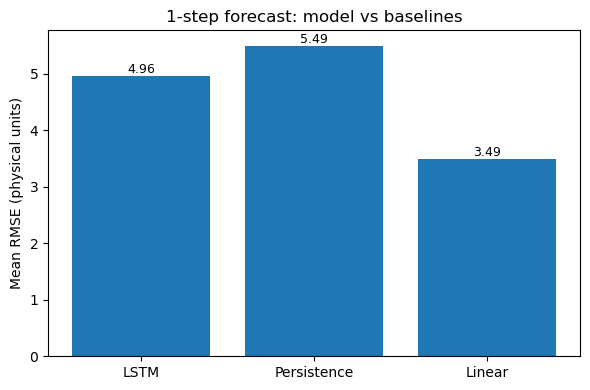

In [3]:
# BASELINE COMPARISON (insert after adaptive horizon metrics cell; before permutation importance)

import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from pathlib import Path

# ---------- build 1-step evaluation windows (normalized) ----------
XW_1, Y1 = [], []
for sid in np.unique(ids):
    m = (ids == sid)
    s = snaps[m]
    x = Xraw[m]
    order = np.argsort(s)
    x = x[order]
    # normalize & clean
    x = (x - mean) / (std + 1e-8)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    if len(x) <= WINDOW:
        continue
    for t in range(WINDOW, len(x)):
        XW_1.append(x[t-WINDOW:t, :])  # [W,F]
        Y1.append(x[t, :])             # [F]
if not XW_1:
    raise RuntimeError("No 1-step windows available. Reduce WINDOW or check data length.")

XW_1 = np.stack(XW_1).astype(np.float32)   # [N,W,F]
Y1    = np.stack(Y1).astype(np.float32)    # [N,F]

# ---------- helper metrics ----------
def rmse(A,B,axis=0): return np.sqrt(np.mean((A-B)**2, axis=axis))
def mae (A,B,axis=0): return np.mean(np.abs(A-B), axis=axis)

# ---------- LSTM predictions (1-step) ----------
@torch.no_grad()
def predict_lstm_next(Xw_norm):
    xb = torch.from_numpy(Xw_norm).float().to(device)
    y  = model(xb).cpu().numpy()             # normalized
    return y

Y_pred_lstm_norm = predict_lstm_next(XW_1)         # [N,F]
Y_pred_lstm = Y_pred_lstm_norm * std + mean        # physical
Y_true      = Y1 * std + mean                      # physical

# ---------- Persistence baseline (copy last frame forward) ----------
XW_1_phys = XW_1 * std + mean
Y_pred_persistence = XW_1_phys[:, -1, :]           # [N,F] physical

# ---------- Linear baseline: multi-output least squares on (window -> next) ----------
# design matrix: flatten window [W,F] => [W*F]
N, W, F = XW_1.shape
X_design = XW_1.reshape(N, W*F)                     # normalized inputs
Y_target = Y1                                       # normalized targets
lam = 1e-3
XtX = X_design.T @ X_design + lam * np.eye(X_design.shape[1])
beta = np.linalg.solve(XtX, X_design.T @ Y_target)  # [W*F, F]
Y_pred_linear_norm = X_design @ beta                # [N,F] normalized
Y_pred_linear = Y_pred_linear_norm * std + mean     # physical

# ---------- compute metrics (per feature + mean) ----------
metrics = []
for name, Y_hat in [
    ("LSTM",        Y_pred_lstm),
    ("Persistence", Y_pred_persistence),
    ("Linear",      Y_pred_linear),
]:
    rmse_f = rmse(Y_hat, Y_true, axis=0)            # per-feature RMSE
    mae_f  = mae (Y_hat, Y_true, axis=0)
    metrics.append({
        "model": name,
        **{f"RMSE_{feat}": float(rmse_f[j]) for j, feat in enumerate(FEATURES)},
        **{f"MAE_{feat}":  float(mae_f[j])  for j, feat in enumerate(FEATURES)},
        "RMSE_mean": float(rmse_f.mean()),
        "MAE_mean":  float(mae_f.mean())
    })

df_metrics = pd.DataFrame(metrics).set_index("model")
out_csv = TAB_DIR / "baseline_comparison_1step.csv"
df_metrics.to_csv(out_csv)
print(f"[Baseline] Saved 1-step comparison table → {out_csv}")
display(df_metrics)

# ---------- simple bar plot (mean RMSE by model) ----------
plt.figure(figsize=(6,4))
plt.bar(df_metrics.index, df_metrics["RMSE_mean"])
plt.ylabel("Mean RMSE (physical units)")
plt.title("1-step forecast: model vs baselines")
for i, v in enumerate(df_metrics["RMSE_mean"].values):
    plt.text(i, v, f"{v:.3g}", ha="center", va="bottom", fontsize=9)
fig_path = FIG_DIR / "baseline_rmse_1step.png"
plt.tight_layout(); plt.savefig(fig_path, dpi=200)
print(f"[Baseline] Saved figure → {fig_path}")


[A] Saved ../data/results/tables/per_feature_metrics_h1.csv and ../data/results/figures/per_feature_errors_h1.png
[A] Saved ../data/results/tables/per_feature_rmse_vs_horizon.csv and ../data/results/figures/per_feature_rmse_vs_horizon.png


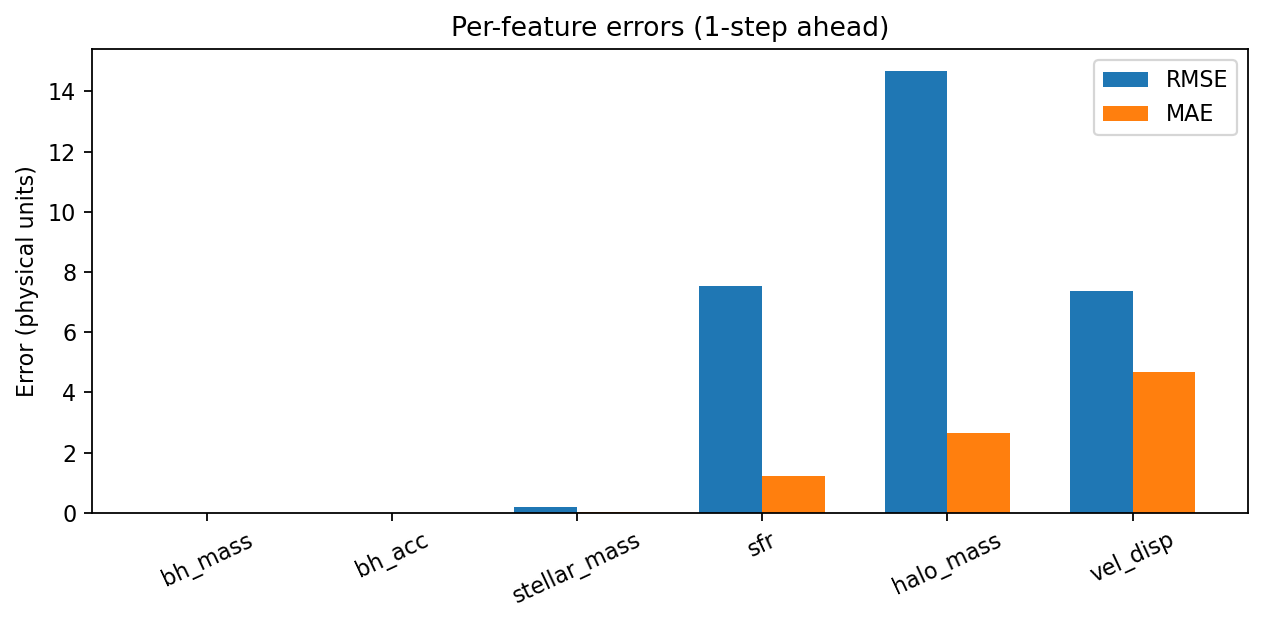

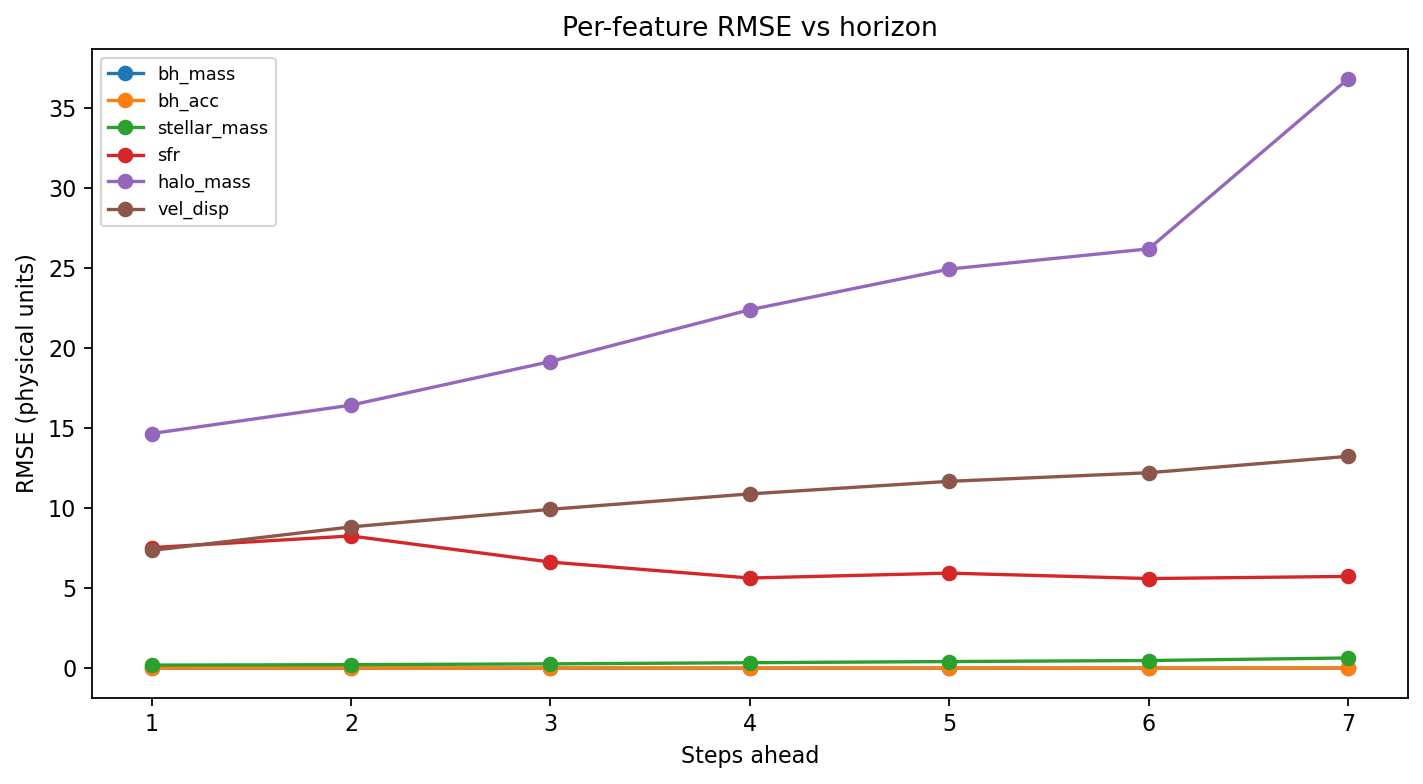

In [3]:
# A — Per-feature RMSE/MAE (h=1 and 1..H)

import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt

def collect_windows_for_h(seqs, h, window):
    XW_list, Y_list = [], []
    for sid, x in seqs.items():
        if len(x) < window + h: 
            continue
        for t in range(window, len(x) - h + 1):
            XW_list.append(x[t-window:t, :])
            Y_list.append(x[t + h - 1, :])
    if not XW_list:
        return None, None
    return np.stack(XW_list).astype(np.float32), np.stack(Y_list).astype(np.float32)

# Build normalized sequences per subhalo (reuses globals: ids, snaps, Xraw, mean, std, WINDOW, FEATURES, model, device, TAB_DIR, FIG_DIR)
seqs = {}
for sid in np.unique(ids):
    m = ids == sid
    s = snaps[m]
    x = Xraw[m][np.argsort(s)]
    x = (x - mean) / (std + 1e-8)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    seqs[int(sid)] = x

@torch.no_grad()
def roll_h(XW_norm, h):
    Xw = torch.from_numpy(XW_norm).float().to(device)
    y_pred = None
    for _ in range(h):
        y_pred = model(Xw)
        # slide window with the newest prediction
        y_exp = y_pred[:, None, :].detach().cpu().numpy()
        Xw_np = Xw.cpu().numpy()
        Xw_np = np.concatenate([Xw_np[:, 1:, :], y_exp], axis=1)
        Xw = torch.from_numpy(Xw_np).float().to(device)
    return y_pred.cpu().numpy()

def rmse(A,B,axis=0): return np.sqrt(np.mean((A-B)**2, axis=axis))
def mae(A,B,axis=0):  return np.mean(np.abs(A-B), axis=axis)

# ---- Horizon 1: per-feature bar chart & CSV
XW1, Y1 = collect_windows_for_h(seqs, 1, WINDOW)
assert XW1 is not None, "No windows for horizon=1."
P1 = roll_h(XW1, 1)                 # normalized
P1_r = P1 * std + mean              # physical
Y1_r = Y1 * std + mean

rmse_1 = rmse(P1_r, Y1_r, axis=0)
mae_1  = mae (P1_r, Y1_r, axis=0)
df1 = pd.DataFrame({"feature": FEATURES, "RMSE": rmse_1, "MAE": mae_1})
out1 = TAB_DIR / "per_feature_metrics_h1.csv"
df1.to_csv(out1, index=False)

plt.figure(figsize=(8,4))
x = np.arange(len(FEATURES))
plt.bar(x - 0.17, rmse_1, width=0.34, label="RMSE")
plt.bar(x + 0.17, mae_1,  width=0.34, label="MAE")
plt.xticks(x, FEATURES, rotation=25)
plt.ylabel("Error (physical units)")
plt.title("Per-feature errors (1-step ahead)")
plt.legend()
fig1 = FIG_DIR / "per_feature_errors_h1.png"
plt.tight_layout(); plt.savefig(fig1, dpi=200)
print(f"[A] Saved {out1} and {fig1}")

# ---- Per-feature RMSE across horizons (adaptive)
H = 10
rows = []
for h in range(1, H+1):
    XWh, Yh = collect_windows_for_h(seqs, h, WINDOW)
    if XWh is None: 
        continue
    Ph = roll_h(XWh, h)
    Ph_r = Ph * std + mean
    Yh_r = Yh * std + mean
    rmse_h = rmse(Ph_r, Yh_r, axis=0)
    rows.append([h] + rmse_h.tolist())

if rows:
    dfH = pd.DataFrame(rows, columns=["horizon"] + FEATURES)
    outH = TAB_DIR / "per_feature_rmse_vs_horizon.csv"
    dfH.to_csv(outH, index=False)

    plt.figure(figsize=(9,5))
    for f in FEATURES:
        plt.plot(dfH["horizon"], dfH[f], marker="o", label=f)
    plt.xlabel("Steps ahead"); plt.ylabel("RMSE (physical units)")
    plt.title("Per-feature RMSE vs horizon")
    plt.legend(fontsize=8)
    figH = FIG_DIR / "per_feature_rmse_vs_horizon.png"
    plt.tight_layout(); plt.savefig(figH, dpi=200)
    print(f"[A] Saved {outH} and {figH}")
else:
    print("[A] No horizons had enough samples for the RMSE vs horizon plot.")


[B] Saved ../data/results/figures/parity_bh_mass.png
[B] Saved ../data/results/figures/parity_bh_acc.png
[B] Saved ../data/results/figures/parity_stellar_mass.png
[B] Saved ../data/results/figures/parity_sfr.png
[B] Saved ../data/results/figures/parity_halo_mass.png
[B] Saved ../data/results/figures/parity_vel_disp.png


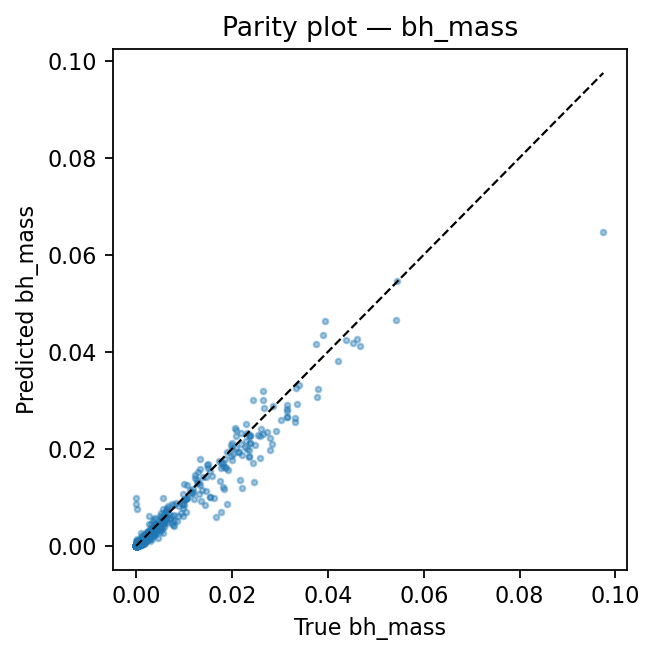

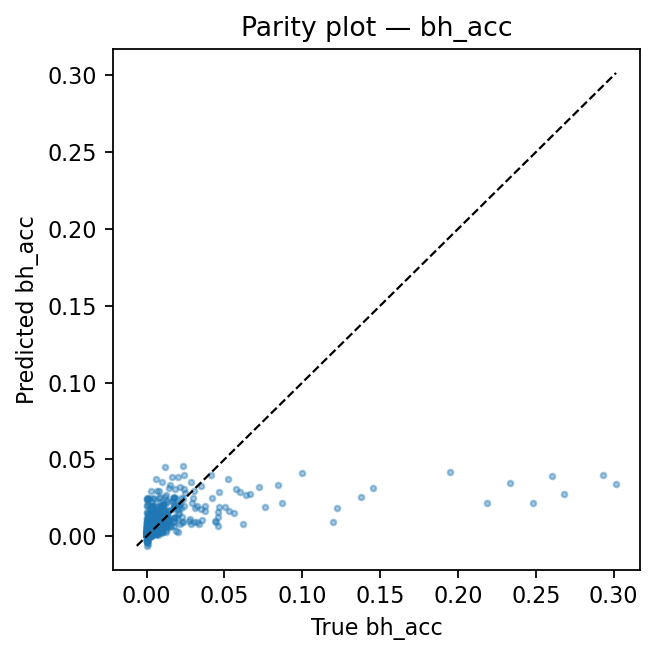

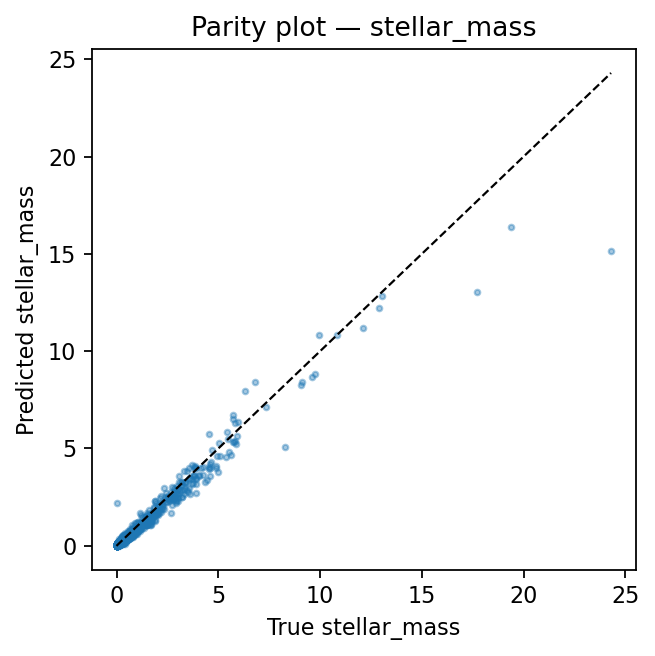

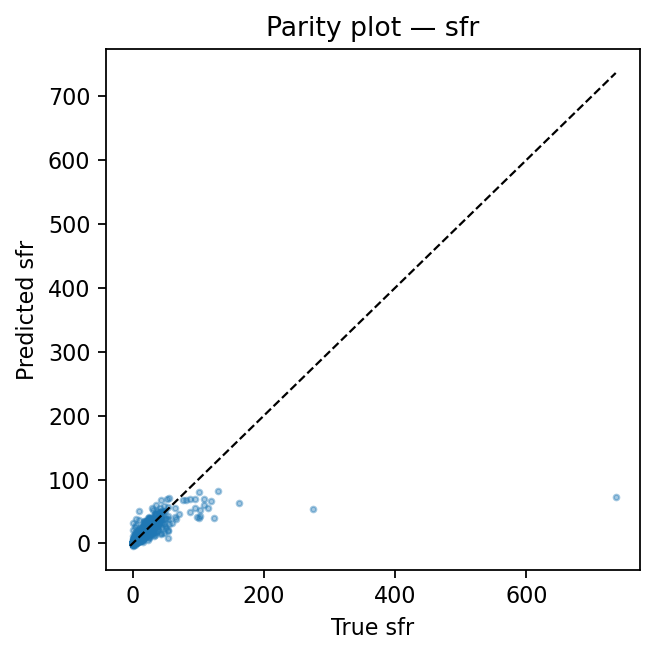

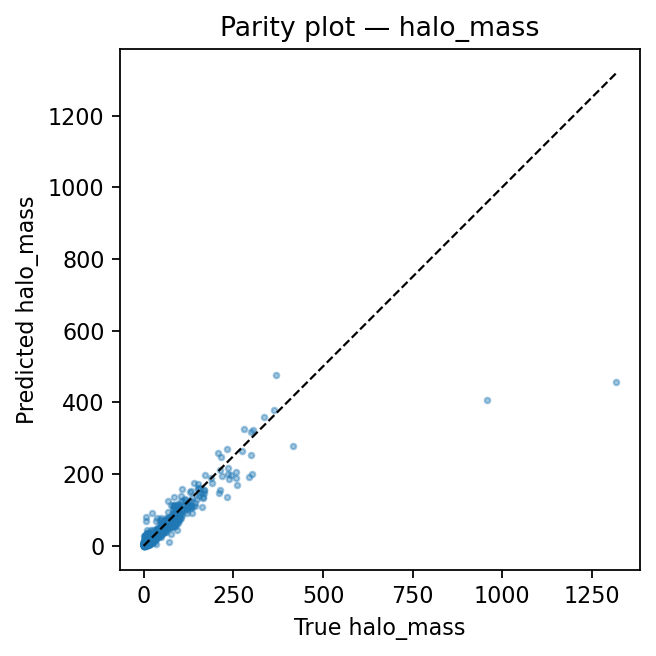

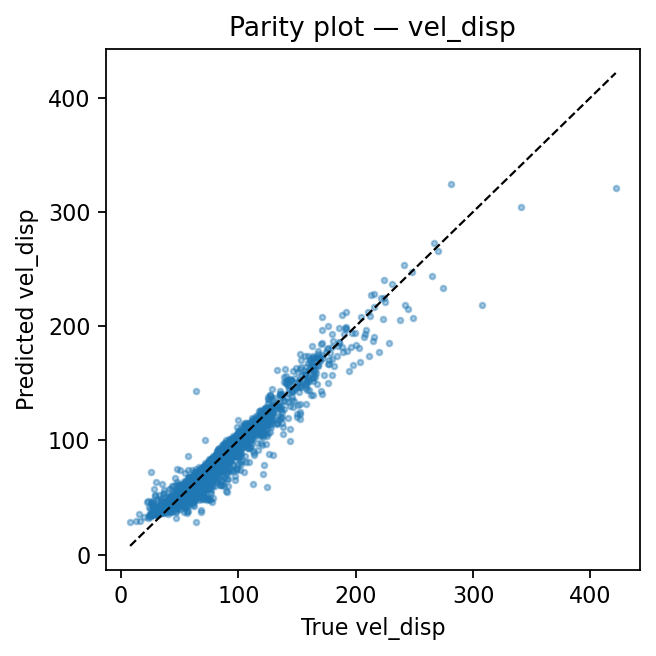

In [4]:
# B — Parity plots (predicted vs true) for each output, horizon=1

import numpy as np, matplotlib.pyplot as plt, torch

# reuse XW1, Y1, P1_r, Y1_r from Cell A
# Subsample for display speed
N_show = min(5000, len(Y1_r))
idx = np.random.default_rng(0).choice(len(Y1_r), size=N_show, replace=False)
Y_show = Y1_r[idx]
P_show = P1_r[idx]

for j, f in enumerate(FEATURES):
    plt.figure(figsize=(4.2,4.2))
    plt.scatter(Y_show[:,j], P_show[:,j], s=6, alpha=0.4)
    lims = [min(Y_show[:,j].min(), P_show[:,j].min()), max(Y_show[:,j].max(), P_show[:,j].max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.xlabel(f"True {f}"); plt.ylabel(f"Predicted {f}")
    plt.title(f"Parity plot — {f}")
    fp = FIG_DIR / f"parity_{f}.png"
    plt.tight_layout(); plt.savefig(fp, dpi=200)
    print(f"[B] Saved {fp}")


[epoch 01/8] [##############################] 100.0%  train=0.243900  val=0.752581  epoch_time=12.9s
[epoch 02/8] [##############################] 100.0%  train=0.244027  val=0.756739  epoch_time=11.7s
[epoch 03/8] [##############################] 100.0%  train=0.239690  val=0.755423  epoch_time=15.2s
[epoch 04/8] [##############################] 100.0%  train=0.238562  val=0.756871  epoch_time=14.7s
[epoch 05/8] [##############################] 100.0%  train=0.235217  val=0.757385  epoch_time=14.3s
[epoch 06/8] [##############################] 100.0%  train=0.237006  val=0.756488  epoch_time=15.1s
[epoch 07/8] [##############################] 100.0%  train=0.232239  val=0.754274  epoch_time=15.6s
[epoch 08/8] [##############################] 100.0%  train=0.236947  val=0.747971  epoch_time=15.4s
Total shadow run time: 114.8s
[OK] Wrote ../data/experiments/metrics_shadow.csv and ../data/results/figures/learning_curve.png (original checkpoint unchanged)


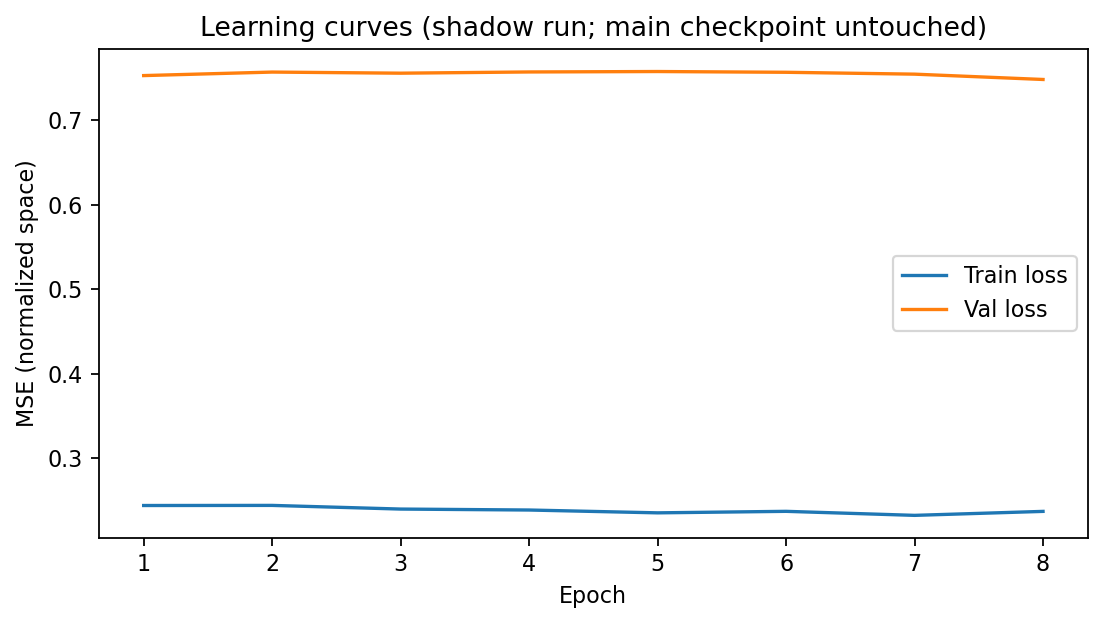

In [4]:
# === Convergence (shadow run) — safe: does NOT modify your main checkpoint ===
# Saves:
#   ../data/results/figures/learning_curve.png
#   ../data/experiments/metrics_shadow.csv

import numpy as np, time, math, copy
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# ----- 0) Sanity: required globals -----
_needed = ["ids","snaps","Xraw","mean","std","WINDOW","FEATURES","device","model","TAB_DIR","FIG_DIR"]
_missing = [n for n in _needed if n not in globals()]
if _missing:
    raise RuntimeError(f"Missing required variables: {_missing}. Re-run your first two setup/model cells.")

# ----- 1) Dirs -----
EXP_DIR = Path("../data/experiments"); EXP_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ----- 2) Build normalized sequences (same preprocessing you used) -----
seqs = {}
for sid in np.unique(ids):
    m = (ids == sid)
    s = snaps[m]
    x = Xraw[m][np.argsort(s)]
    x = (x - mean) / (std + 1e-8)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    if len(x) > WINDOW:   # need at least W+1
        seqs[int(sid)] = x

if not seqs:
    raise RuntimeError("No sequences found (after normalization). Check data and WINDOW.")

# ----- 3) Train/Val split by subhalo (no leakage) -----
rng = np.random.default_rng(123)
sid_all = np.array(list(seqs.keys()))
rng.shuffle(sid_all)
n_train = max(1, int(0.8 * len(sid_all)))
train_ids, val_ids = sid_all[:n_train], sid_all[n_train:]

def make_pairs(sids):
    XW, Y = [], []
    for sid in sids:
        x = seqs[int(sid)]
        for t in range(WINDOW, len(x)):
            XW.append(x[t-WINDOW:t, :])
            Y.append(x[t, :])
    if not XW:
        return None, None
    return np.stack(XW).astype(np.float32), np.stack(Y).astype(np.float32)

Xtr, Ytr = make_pairs(train_ids)
Xva, Yva = make_pairs(val_ids)
if Xtr is None or Xva is None:
    raise RuntimeError("Not enough samples for shadow training. Try reducing WINDOW.")

class PairDS(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return torch.from_numpy(self.X[i]), torch.from_numpy(self.Y[i])

BATCH = 64
train_loader = DataLoader(PairDS(Xtr, Ytr), batch_size=BATCH, shuffle=True, drop_last=False)
val_loader   = DataLoader(PairDS(Xva, Yva), batch_size=BATCH, shuffle=False, drop_last=False)

# ----- 4) Clone your model (don’t touch original) -----
shadow = copy.deepcopy(model).to(device)
for p in shadow.parameters(): p.requires_grad_(True)

crit = nn.MSELoss()
optimizer = torch.optim.Adam(shadow.parameters(), lr=5e-5)  # small LR, stable curve
EPOCHS = 8

# ----- 5) Training with live progress -----
def eval_loss(net, loader):
    net.eval()
    s = 0.0; n = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, dtype=torch.float32); yb = yb.to(device, dtype=torch.float32)
            s += crit(net(xb), yb).item() * xb.size(0); n += xb.size(0)
    return s / max(n,1)

def _bar(pct, w=30):
    k = int(pct*w)
    return "[" + "#"*k + "-"*(w-k) + f"] {pct*100:5.1f}%"

train_losses, val_losses = [], []
t_start = time.perf_counter()

for ep in range(1, EPOCHS+1):
    shadow.train()
    s = 0.0; n = 0
    Nbatch = len(train_loader)
    t0 = time.perf_counter()
    last_tick = time.perf_counter()

    for i, (xb, yb) in enumerate(train_loader, start=1):
        xb = xb.to(device, dtype=torch.float32); yb = yb.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        loss = crit(shadow(xb), yb)
        loss.backward()
        nn.utils.clip_grad_norm_(shadow.parameters(), 1.0)
        optimizer.step()
        s += loss.item() * xb.size(0); n += xb.size(0)

        # progress update ~10 times per epoch
        if i == 1 or i == Nbatch or i % max(1, (Nbatch // 10)) == 0:
            pct = i / Nbatch
            dt  = time.perf_counter() - t0
            it_per_s = i / dt if dt > 0 else 0.0
            eta = (Nbatch - i) / it_per_s if it_per_s > 0 else float("inf")
            print(f"\r[epoch {ep:02d}/{EPOCHS}] {_bar(pct)}  "
                  f"batch {i:4d}/{Nbatch}  "
                  f"ETA {eta:5.1f}s", end="")
    tr = s / max(n,1)
    va = eval_loss(shadow, val_loader)
    train_losses.append(tr); val_losses.append(va)
    print(f"\r[epoch {ep:02d}/{EPOCHS}] {_bar(1.0)}  train={tr:.6f}  val={va:.6f}  "
          f"epoch_time={time.perf_counter()-t0:.1f}s")

print(f"Total shadow run time: {time.perf_counter()-t_start:.1f}s")

# ----- 6) Save CSV + figure -----
df = pd.DataFrame({"epoch": np.arange(1, EPOCHS+1),
                   "train_loss": train_losses, "val_loss": val_losses})
csv_path = EXP_DIR / "metrics_shadow.csv"
df.to_csv(csv_path, index=False)

plt.figure(figsize=(7,4))
plt.plot(df["epoch"], df["train_loss"], label="Train loss")
plt.plot(df["epoch"], df["val_loss"],   label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("MSE (normalized space)")
plt.title("Learning curves (shadow run; main checkpoint untouched)")
plt.legend()
fig_path = FIG_DIR / "learning_curve.png"
plt.tight_layout(); plt.savefig(fig_path, dpi=200)
print(f"[OK] Wrote {csv_path} and {fig_path} (original checkpoint unchanged)")
